# Evaluate hyperparameters for model using the crunchy-snow dataset

In [1]:
parent_dir = '/home/jovyan/crunchy-snow'

## Setup:

In [ ]:
import os

os.chdir(parent_dir)
!pip install -e .
!pip install optuna

Obtaining file:///home/jovyan/crunchy-snow
  Preparing metadata (setup.py) ... done
  Attempting uninstall: crunchy-snow
    Found existing installation: crunchy-snow 0.1
    Uninstalling crunchy-snow-0.1:
      Successfully uninstalled crunchy-snow-0.1
  Running setup.py develop for crunchy-snow
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/15/da/68883911855d8b4d521f9a370e4e6aab8232b91c1d8d5a8348c4680c6642/optuna-3.6.1-py3-none-any.whl.metadata
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)


In [ ]:
#!mamba env create -f environment.yml 
# !conda init
# !conda activate crunchy-snow

## Code:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import seaborn as sns

import torch
from torch.utils.data import DataLoader
import torch.optim as optim                   # Package for implementing various optimization algorithms

import torch.nn as nn
import torch.nn.functional as F               # Functions (convolution, activation, loss, etc.)

from tqdm import tqdm
import pickle

import crunchy_snow.models
import crunchy_snow.dataset

import sklearn.metrics as skmetrics
import optuna

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

SEED = 10
torch.manual_seed(SEED)

ModuleNotFoundError: No module named 'optuna'

In [ ]:
available_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Available device: {available_device}")

In [ ]:
# flag for whether GPUs are available

if available_device == 'cuda':
    gpus = True

## Prepare dataloader

In [5]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [6]:
len(train_path_list)

12382

In [7]:
len(val_path_list)

2160

In [17]:
# to test code with a small sample of the data
import random
random.seed(SEED)

n_imgs = 10# 100 # 16

train_path_list = random.sample(train_path_list, n_imgs)
val_path_list = random.sample(val_path_list, n_imgs)

In [9]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

In [18]:
# prepare training and validation dataloaders

train_batch = 6# 60#16
validation_batch = 2 #20

train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=train_batch, shuffle=True)

val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=validation_batch, shuffle=True)

In [11]:
print(selected_channels)

['aso_sd', 'aso_gap_map', 'snowon_vv', 'snowon_vh', 'snowoff_vv', 'snowoff_vh', 'snowon_vv_mean', 'snowon_vh_mean', 'snowoff_vv_mean', 'snowoff_vh_mean', 'snowon_cr', 'snowoff_cr', 'delta_cr', 'rtc_gap_map', 'rtc_mean_gap_map', 'aerosol_optical_thickness', 'coastal_aerosol', 'blue', 'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'nir', 'water_vapor', 'swir1', 'swir2', 'scene_class_map', 'water_vapor_product', 'ndvi', 'ndsi', 'ndwi', 's2_gap_map', 'fcf', 'elevation', 'latitude', 'longitude', 'dowy']


In [19]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr',
    'scene_class_map' # new var
]

In [20]:
omitted_channels = np.setdiff1d(selected_channels,input_channels)
print(omitted_channels)

['aerosol_optical_thickness' 'aso_gap_map' 'aso_sd' 'coastal_aerosol'
 'delta_cr' 'dowy' 'latitude' 'longitude' 'nir' 'red_edge1' 'red_edge2'
 'red_edge3' 'rtc_gap_map' 'rtc_mean_gap_map' 's2_gap_map'
 'snowoff_vh_mean' 'snowoff_vv_mean' 'snowon_vh_mean' 'snowon_vv_mean'
 'swir1' 'swir2' 'water_vapor' 'water_vapor_product']


## Hyperparameter tuning:

In [21]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    #epochs = trial.suggest_int('epochs', 10, 50)
    epochs = trial.suggest_int('epochs', 1, 5)

    # Initialize the model, optimizer, and loss function
    model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))

    if gpus == True:
        model.to('cuda');  # Run on GPU

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    train_loss = []
    val_loss = []

    # Training and validation loop
    for epoch in range(epochs):
        print(f'\nStarting epoch {epoch+1}')
        epoch_loss = []
        val_temp_loss = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
        for data_tuple in pbar:
            model.train()
            optimizer.zero_grad()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            
            # prepare inputs by concatenating along channel dimension
            if gpus == True:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            else:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            if gpus == True:
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
            else:
                pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
                aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
            
            # Calculate loss
            if gpus == True:
                loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                epoch_loss.append(loss.item())
            else:
                loss = loss_fn(pred_sd, aso_sd)
                epoch_loss.append(loss.item())
                
            # Update tqdm progress bar with batch loss
            pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})
    
            loss.backward()  # Propagate the gradients in backward pass
            optimizer.step()

        
        train_loss.append(np.mean(epoch_loss))
        print(f'Training loss: {np.mean(epoch_loss)}')

        for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
            with torch.no_grad():
                model.eval()

                # read data into dictionary
                data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
                
                # prepare inputs by concatenating along channel dimension
                if gpus == True:
                    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
                else:
                    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
    
                # generate prediction
                pred_sd = model(inputs)
        
                # Limit prediction to areas with valid data
                if gpus == True:
                    pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                    aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
                    print('Predictions on cuda')
                else:
                    pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
                    aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
                    print('Predictions on cpu')
                    
                # Calculate loss
                if gpus == True:
                    loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                    val_temp_loss.append(loss.item())
                else:
                    loss = loss_fn(pred_sd, aso_sd)
                    val_temp_loss.append(loss.item())
        
        val_loss.append(np.mean(val_temp_loss))
        print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # Return the validation loss of the last epoch (or the best one)
    return val_loss[-1]


In [31]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="optm_test_3",
    pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=1)  # Adjust n_trials as needed


[I 2024-08-22 19:01:58,465] A new study created in RDB with name: optm_test_3



Starting epoch 1


Epoch 1/4: 100%|████████████████████████████████████████| 2/2 [00:00<00:00,  3.20batch/s, batch loss=0.258, mean epoch loss=0.131]


Training loss: 0.13067970960400999


Validation:  20%|██        | 1/5 [00:00<00:00,  7.75batch/s]

Predictions on cuda


Validation:  40%|████      | 2/5 [00:00<00:00,  7.98batch/s]

Predictions on cuda


Validation:  60%|██████    | 3/5 [00:00<00:00,  7.98batch/s]

Predictions on cuda


Validation:  80%|████████  | 4/5 [00:00<00:00,  8.03batch/s]

Predictions on cuda


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.01batch/s]


Predictions on cuda
Validation loss: 0.00918201394379139

Starting epoch 2


Epoch 2/4: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.19batch/s, batch loss=0.0104, mean epoch loss=0.00842]


Training loss: 0.008419761899858713


Validation:  20%|██        | 1/5 [00:00<00:00,  7.78batch/s]

Predictions on cuda


Validation:  40%|████      | 2/5 [00:00<00:00,  7.64batch/s]

Predictions on cuda


Validation:  60%|██████    | 3/5 [00:00<00:00,  7.74batch/s]

Predictions on cuda


Validation:  80%|████████  | 4/5 [00:00<00:00,  7.76batch/s]

Predictions on cuda


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.76batch/s]


Predictions on cuda
Validation loss: 545.1631958007813

Starting epoch 3


Epoch 3/4: 100%|█████████████████████████████████████████| 2/2 [00:00<00:00,  3.16batch/s, batch loss=0.0339, mean epoch loss=240]


Training loss: 240.0028543304652


Validation:  20%|██        | 1/5 [00:00<00:00,  7.06batch/s]

Predictions on cuda


Validation:  40%|████      | 2/5 [00:00<00:00,  7.32batch/s]

Predictions on cuda


Validation:  60%|██████    | 3/5 [00:00<00:00,  7.71batch/s]

Predictions on cuda


Validation:  80%|████████  | 4/5 [00:00<00:00,  7.89batch/s]

Predictions on cuda


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.79batch/s]


Predictions on cuda
Validation loss: 0.03228400647640228

Starting epoch 4


Epoch 4/4: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  3.18batch/s, batch loss=0.0184, mean epoch loss=0.0205]


Training loss: 0.020549600012600422


Validation:  20%|██        | 1/5 [00:00<00:00,  6.38batch/s]

Predictions on cuda


Validation:  40%|████      | 2/5 [00:00<00:00,  6.66batch/s]

Predictions on cuda


Validation:  60%|██████    | 3/5 [00:00<00:00,  7.26batch/s]

Predictions on cuda


Validation:  80%|████████  | 4/5 [00:00<00:00,  7.49batch/s]

Predictions on cuda


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.32batch/s]

Predictions on cuda
Validation loss: 0.018450804241001605



[I 2024-08-22 19:02:05,138] Trial 0 finished with value: 0.018450804241001605 and parameters: {'learning_rate': 0.002060449286627467, 'weight_decay': 1.1541329711371676e-05, 'epochs': 4}. Best is trial 0 with value: 0.018450804241001605.


In [32]:
# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)

Best hyperparameters:  {'learning_rate': 0.002060449286627467, 'weight_decay': 1.1541329711371676e-05, 'epochs': 4}
Best validation loss:  0.018450804241001605


/tmp/ipykernel_1874/1426035912.py:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

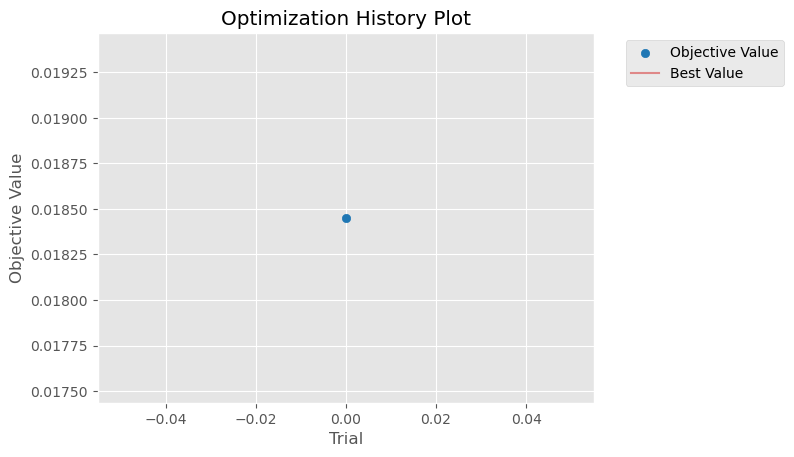

In [33]:
# Tells you which trial has best parameters

plot_optimization_history(study)

/tmp/ipykernel_1874/3988485508.py:1: ExperimentalWarning:

plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.

[W 2024-08-22 19:02:44,014] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Axes: title={'center': 'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

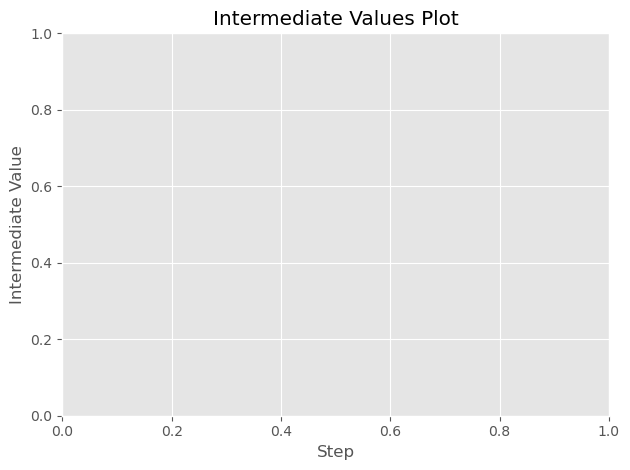

In [34]:
plot_intermediate_values(study)

## Train model

In [ ]:
# import model
# model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
#model = crunchy_snow.models.UNet(n_input_channels=len(input_channels))           
# model = crunchy_snow.models.ResUNet(n_input_channels=len(input_channels))                # predicted fields are smooth
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = crunchy_snow.models.VisionTransformer(n_input_channels=len(input_channels))      # predicted fields are noisy

if gpus == True:
    model.to('cuda');  # Run on GPU

# name your model
model_name = 'mandachasteen_ResDepth_sceneclassmap'

In [ ]:
# Define optimizer and loss function

learning_rate = 0.0003
epochs = 16

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        
        # prepare inputs by concatenating along channel dimension
        if gpus == True:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        else:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        if gpus == True:
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
        else:
            pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
        
        # Calculate loss
        if gpus == True:
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            epoch_loss.append(loss.item())
        else:
            loss = loss_fn(pred_sd, aso_sd)
            epoch_loss.append(loss.item())
            
        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            
            # prepare inputs by concatenating along channel dimension
            if gpus == True:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            else:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            if gpus == True:
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
                print('Predictions on cuda')
            else:
                pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
                aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
                print('Predictions on cpu')
                
            # Calculate loss
            if gpus == True:
                loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                val_temp_loss.append(loss.item())
            else:
                loss = loss_fn(pred_sd, aso_sd)
                val_temp_loss.append(loss.item())
                
    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)

### Plot loss:

In [ ]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

ax.set_xlim([0,epochs-1])
ax.set_xticks(np.arange(0,epochs,1))


# save figure
#plt.savefig(f'/home/jovyan/crunchy-snow/figs/{model_name}_loss.png', dpi=300)

## Examine results

In [ ]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=1, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=1, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
        # save figure
        #plt.savefig(f'../../../figs/{model_name}_prediction.png', dpi=300)
        
    else:
        break

In [ ]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

# add sample index to plot
plot_sample = 3

for i, data_tuple in enumerate(val_loader):
    #if i < num_samples:
    if i == 1:  
        print(i)
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=1, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=1, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-1, vmax=1, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            #f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            #plt.tight_layout()
            # save figure
            #plt.savefig(f'../../../figs/{model_name}_prediction_err.png', dpi=300)
    else: 
        #break
        continue

## Visualize model predictions next to baseline model:

In [ ]:
# specify input channels used in baseline model

input_channels_bl = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr'
]

In [ ]:
#load previous model
model_bl = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels_bl))

model_baseline = 'quinn_ResDepth_v3'
# GPU:
if gpus == True:
    model_bl.load_state_dict(torch.load('/home/jovyan/crunchy-snow/weights/'+model_baseline))
    model_bl.to('cuda');    # to gpu memory from cpu 
    print('baseline model on cuda')
    
# CPU:
else:
    model_bl.load_state_dict(torch.load('/home/jovyan/crunchy-snow/weights/'+model_baseline, map_location=torch.device('cpu')))
    print('baseline model on cpu')

In [ ]:
# visualize predictions from baseline and new model

# ----------------------------
# specify sample index to plot
plot_sample = 10
#
# ----------------------------


sns.set_theme()
norm_dict = crunchy_snow.dataset.norm_dict


for i, data_tuple in enumerate(val_loader):
    print(i)
    if i == plot_sample:
        print(i)
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction

            if gpus == True:
                # baseline model:
                inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1).to('cuda')
                pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model
                pred_sd_bl = pred_sd_bl.to('cpu')

                # new test model:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
                pred_sd = model(inputs)  # Generate predictions using the model
                pred_sd = pred_sd.to('cpu')

                # lidar data:
                aso_sd = aso_sd.to('cpu')

                # elevation:
                elev = data_dict['elevation'].to('cpu')
            
            else:
                # baseline model:
                inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1)
                pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model

                # new test model:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
                pred_sd = model(inputs)  # Generate predictions using the model
            
        f, axs = plt.subplots(3, 2, figsize=(10, 18))#, sharex=True, sharey=True)
        f.patch.set_facecolor('white')

        ax = axs.flatten()

        # modify plot style
        for a in ax:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)

        # undo normalization to calculate max
        pred_sd_unnorm = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        aso_sd_unnorm = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        pred_sd_bl_unnorm = crunchy_snow.dataset.undo_norm(pred_sd_bl, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        
        elev_unnorm = crunchy_snow.dataset.undo_norm(elev, crunchy_snow.dataset.norm_dict['elevation']).squeeze()
        
        # calculate max:
        pred_sd_max = np.round(float(pred_sd_unnorm.max()),1)
        aso_sd_max = np.round(float(aso_sd_unnorm.max()),1)
        pred_sd_bl_max = np.round(float(pred_sd_bl_unnorm.max()),1)
        elev_max = np.round(float(elev_unnorm.max()),1)

        pred_bl_diff_max = np.round(float(np.abs(pred_sd_bl_unnorm-aso_sd_unnorm).max()),1)
        pred_diff_max = np.round(float(np.abs(pred_sd_unnorm-aso_sd_unnorm).max()),1)

        ####### Plots:
        
        # Baseline model:
        im0 = ax[0].imshow(pred_sd_bl.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0].set_title(r'Predicted Snow Depth: $\it{Baseline\ Model}$', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[0].text(0.87, -0.05, 'Max Depth:\n'+str(pred_sd_bl_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.9, 'LR: '+str(0.0003), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.85, 'Epochs: '+str(50), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.8, 'Batch: '+str(16), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 

        
        # Add axis for predicted snow depth colorbar
        cax0 = ax[0].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb0 = f.colorbar(im0, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[0], cax=cax0)
        cb0.outline.set_visible(True)
        cb0.outline.set_linewidth(0.5)
        cb0.outline.set_edgecolor('black')

        # ----
        
        # Difference -- baseline - observations:
        im1 = ax[1].imshow((pred_sd_bl - aso_sd).squeeze(), cmap='RdBu_r', vmin=-0.4, vmax=0.4, interpolation='none') 
        ax[1].set_title(r'Baseline Snow Depth $-$ ASO Snow Depth', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[1].text(0.87, -0.05, 'Max Error Magnitude:\n'+str(pred_bl_diff_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[1].transAxes, color='gray', zorder=12) 


        # Add axis for differences colorbar
        cax1 = ax[1].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb1 = f.colorbar(im1, extend='both', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[1], cax=cax1)
        cb1.outline.set_visible(True)
        cb1.outline.set_linewidth(0.5)
        cb1.outline.set_edgecolor('black')    
        
        # ----
        
        # New model:
        im2 = ax[2].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[2].set_title(r'Predicted Snow Depth: $\it{Test\ Model}$', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[2].text(0.87, -0.05, 'Max Depth:\n'+str(pred_sd_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.95, '# Samples: '+str(n_imgs), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.9, 'LR: '+str(learning_rate), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.85, 'Epochs: '+str(epochs), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.8, 'Batch: '+str(train_batch), fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 

        
        # Add axis for predicted snow depth colorbar
        cax2 = ax[2].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb2 = f.colorbar(im2, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[2], cax=cax2)
        cb2.outline.set_visible(True)
        cb2.outline.set_linewidth(0.5)
        cb2.outline.set_edgecolor('black')
        
        # ----
        
        # Difference -- new model - observations:
        im3 = ax[3].imshow((pred_sd - aso_sd).squeeze(), cmap='RdBu_r', vmin=-0.4, vmax=0.4, interpolation='none') 
        ax[3].set_title(r'Test Snow Depth $-$ ASO Snow Depth', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[3].text(0.87, -0.05, 'Max Error Magnitude:\n'+str(pred_diff_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[3].transAxes, color='gray', zorder=12) 

        
        # Add axis for differences colorbar
        cax3 = ax[3].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb3 = f.colorbar(im3, extend='both', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[3], cax=cax3)
        cb3.outline.set_visible(True)
        cb3.outline.set_linewidth(0.5)
        cb3.outline.set_edgecolor('black')   
        
        # ----
        
        # Lidar snow depth:
        im4 = ax[4].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[4].set_title('ASO Lidar Snow Depth',fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[4].text(0.87, -0.05, 'Max Depth:\n'+str(aso_sd_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[4].transAxes, color='gray', zorder=12) 


        # Add axis for observed snow depth colorbar
        cax4 = ax[4].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb4 = f.colorbar(im4, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[4], cax=cax4)
        cb4.outline.set_visible(True)
        cb4.outline.set_linewidth(0.5)
        cb4.outline.set_edgecolor('black')

        # ----
        
        # Elevation:
        im5 = ax[5].imshow(data_dict['elevation'].squeeze(), cmap='gist_earth', vmin=0, vmax=0.7, interpolation=None)
        ax[5].set_title('Copernicus DEM',fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[5].text(0.87, -0.05, 'Max Elevation:\n'+str(elev_max)+' m', fontsize=7, fontweight='medium', ha='center', va='center', transform=ax[5].transAxes, color='gray', zorder=12) 


        # Add axis for elevation colorbar
        cax5 = ax[5].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb5 = f.colorbar(im5, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[5], cax=cax5)
        cb5.outline.set_visible(True)
        cb5.outline.set_linewidth(0.5)
        cb5.outline.set_edgecolor('black')
        
        # Clean up subplots / layout.
        f.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.45, hspace=0.4)

        plt.savefig(f'/home/jovyan/crunchy-snow/figs/snowdepth_{model_baseline}_{model_name}_sample{plot_sample}_{n_imgs}imgs_{epochs}epochs.png', dpi=300)


    else:
        #break
        continue

In [ ]:
# Plot RMSE and max error for each sample

nsample = []
rmse_pred_sd = []
max_err_pred_sd = []

rmse_pred_sd_bl = []
max_err_pred_sd_bl = []

for i, data_tuple in enumerate(val_loader):
    nsample.append(i)

    # read data into dictionary
    data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

    with torch.no_grad():
        # Concatenate input feature channels, make prediction

        if gpus == True:
            
            # baseline model:
            inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1).to('cuda')
            pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model
            pred_sd_bl = pred_sd_bl.to('cpu')

            # new test model:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # lidar data:
            aso_sd = aso_sd.to('cpu')
        
        else:
            # baseline model:
            inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1)
            pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model

            # new test model:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
            pred_sd = model(inputs)  # Generate predictions using the model

        # undo normalization to calculate max
        pred_sd_unnorm = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        aso_sd_unnorm = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        pred_sd_bl_unnorm = crunchy_snow.dataset.undo_norm(pred_sd_bl, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()

        pred_sd_rmse = skmetrics.mean_squared_error(aso_sd_unnorm, pred_sd_unnorm, squared=False)   
        rmse_pred_sd.append(pred_sd_rmse)

        pred_sd_maxerr = skmetrics.max_error(aso_sd_unnorm.flatten(), pred_sd_unnorm.flatten())
        max_err_pred_sd.append(pred_sd_maxerr)

        pred_sd_bl_rmse = skmetrics.mean_squared_error(aso_sd_unnorm, pred_sd_bl_unnorm, squared=False)   
        rmse_pred_sd_bl.append(pred_sd_bl_rmse)

        pred_sd_bl_maxerr = skmetrics.max_error(aso_sd_unnorm.flatten(), pred_sd_bl_unnorm.flatten())
        max_err_pred_sd_bl.append(pred_sd_bl_maxerr)


In [ ]:
# plot error for each sample

sns.set_theme()

f, axs = plt.subplots(2,1,figsize=(10,7))

ax = axs.flatten()

# RMSE for models
ax[0].plot(rmse_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[0].plot(rmse_pred_sd, color='xkcd:blue green', label='Test Model')

ax[0].set_xlim([0,len(rmse_pred_sd)-1])
ax[0].set_xticks(np.arange(0,len(rmse_pred_sd_bl),1))
ax[0].set_ylim([0,max(np.maximum(rmse_pred_sd_bl,rmse_pred_sd))+0.2])

ax[0].set_title(r'Snow Depth RMSE Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[0].legend()

# Max errors for models
ax[1].plot(max_err_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[1].plot(max_err_pred_sd, color='xkcd:blue green', label='Test Model')

ax[1].set_xlim([0,len(max_err_pred_sd_bl)-1])
ax[1].set_xticks(np.arange(0,len(max_err_pred_sd_bl),1))
ax[1].set_ylim([int(min(np.minimum(max_err_pred_sd_bl,max_err_pred_sd))-0.2),max(np.maximum(max_err_pred_sd_bl,max_err_pred_sd))+0.2])

ax[1].set_title(r'Snow Depth Max Error Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[1].legend()

# Clean up subplots / layout.
f.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.9, wspace=0.45, hspace=0.4)


# save figure
plt.savefig(f'/home/jovyan/crunchy-snow/figs/errorpersample_{model_baseline}_{model_name}_{n_imgs}imgs_{epochs}eps.png', dpi=300)
